# Question
Using publicly available data at data.gov.sg please create a model pipeline to forecast (upcoming 3 hours) the traffic flow at the specified location (latitude: 1.357098686 longitude: 103.902042), for a specified time of day. 

The solution must have the following components:

(1) Estimation of historical traffic flow, using image data sets available here (https://data.gov.sg/dataset/traffic-images).

(2) Use the pipeline from (1) and weather data (https://data.gov.sg/dataset/realtime-weather-readings), to forecast the traffic flow at the specified location at a specified time of day.

Notes: You may use any additional data sources / APIs to build your models.

In [ ]:
pip install pandas

In [ ]:
pip install opencv-python

In [ ]:
pip install Pillow

In [ ]:
pip install matplotlib

In [ ]:
pip install keras-ocr

In [ ]:
pip install tensorflow

In [ ]:
pip install sklearn

### Importing all all libraries used in this study.

In [80]:
import numpy as np
import pandas as pd
import math
import os
import time

import matplotlib.pyplot as plt
import matplotlib.dates as md

from urllib.request import urlopen
import json

import requests
from io import BytesIO
from PIL import Image, ImageOps

import keras_ocr
import cv2

from tqdm import tqdm

from skimage import io

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error, r2_score

import pickle

# 1) Data verification
We open traffic image and weather data of any time instances to understand how it is formatted.

From that, we learnt that the format is in .json.

With that, we can deploy pandas and utilize the fact that it is stored in a nested dictionary to reformat the data structure into a usable form.

In [3]:
# Extract traffic image
url = 'https://api.data.gov.sg/v1/transport/traffic-images'
response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')
df_imag = json.loads(json_data)
print(df_imag)

# Extract air temperature data
url = 'https://api.data.gov.sg/v1//environment/air-temperature'
response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')
df_temp = json.loads(json_data)
print(df_temp)

{'items': [{'timestamp': '2022-03-28T12:34:56+08:00', 'cameras': [{'timestamp': '2022-03-28T12:34:16+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2022/03/3ad6acd9-1747-41a1-9e64-caf72a6b4dcb.jpg', 'location': {'latitude': 1.29531332, 'longitude': 103.871146}, 'camera_id': '1001', 'image_metadata': {'height': 240, 'width': 320, 'md5': '7bb94e54a5133e6550c38f541c9dc845'}}, {'timestamp': '2022-03-28T12:34:16+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2022/03/c7c067c1-32e3-4c63-8b11-d07332bcf65c.jpg', 'location': {'latitude': 1.319541067, 'longitude': 103.8785627}, 'camera_id': '1002', 'image_metadata': {'height': 240, 'width': 320, 'md5': 'e028b9134c7b43ca3f3cf471311de516'}}, {'timestamp': '2022-03-28T12:34:16+08:00', 'image': 'https://images.data.gov.sg/api/traffic-images/2022/03/9d2dfabc-dab5-49d1-afa0-8f0b96b71eea.jpg', 'location': {'latitude': 1.323957439, 'longitude': 103.8728576}, 'camera_id': '1003', 'image_metadata': {'height': 240, 'width':

We reformat the traffic data to get the image URL and location.

In [4]:
# Extract traffic image
url = 'https://api.data.gov.sg/v1/transport/traffic-images'
response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')
df_imag = json.loads(json_data)

imag_status = df_imag['api_info']['status']
imag_timestamp = df_imag['items'][0]['timestamp']

imag_date = imag_timestamp.split('T')[0]
imag_time_zone = imag_timestamp.split('T')[1]

imag_time = imag_time_zone.split('+')[0]
imag_time_SG = imag_time_zone.split('+')[1]

imag_cameras = df_imag['items'][0]['cameras']

imag_cameras = pd.DataFrame.from_dict(imag_cameras)

# Convert location into latitude and longitude
imag_cameras[['latitude', 'longitude']] = imag_cameras['location'].apply(pd.Series)
imag_cameras = imag_cameras.drop(['location'], axis=1)

imag_cameras[['height', 'width', 'md5']] = imag_cameras['image_metadata'].apply(pd.Series)
imag_cameras = imag_cameras.drop(['image_metadata'], axis=1)

imag_cameras['status'] = imag_status
imag_cameras['date'] = imag_date
imag_cameras['time'] = imag_time
imag_cameras['time zone'] = imag_time_SG

imag_cameras.drop_duplicates()
imag_final = imag_cameras

print(imag_final)

                    timestamp  \
0   2022-03-28T12:34:16+08:00   
1   2022-03-28T12:34:16+08:00   
2   2022-03-28T12:34:16+08:00   
3   2022-03-28T12:34:16+08:00   
4   2022-03-28T12:34:16+08:00   
..                        ...   
82  2022-03-28T12:34:16+08:00   
83  2022-03-28T12:34:16+08:00   
84  2022-03-28T12:34:16+08:00   
85  2022-03-28T12:20:16+08:00   
86  2022-03-28T12:20:16+08:00   

                                                image camera_id  latitude  \
0   https://images.data.gov.sg/api/traffic-images/...      1001  1.295313   
1   https://images.data.gov.sg/api/traffic-images/...      1002  1.319541   
2   https://images.data.gov.sg/api/traffic-images/...      1003  1.323957   
3   https://images.data.gov.sg/api/traffic-images/...      1004  1.319536   
4   https://images.data.gov.sg/api/traffic-images/...      1005  1.363520   
..                                                ...       ...       ...   
82  https://images.data.gov.sg/api/traffic-images/...      9704 

We reformat the temperature data to get the temperature and location.

In [5]:
# Extract air temperature data
url = 'https://api.data.gov.sg/v1//environment/air-temperature'
response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')
df_temp = json.loads(json_data)

# Get status
temp_status = df_temp['api_info']['status'] 

# Get timestamp
temp_timestamp = df_temp['items'][0]['timestamp']

temp_date = temp_timestamp.split('T')[0]
temp_time_zone = temp_timestamp.split('T')[1]

temp_time = temp_time_zone.split('+')[0]
temp_time_SG = temp_time_zone.split('+')[1]

# Get readings
temp_readings = pd.DataFrame(df_temp['items'][0]['readings'])
temp_reading_type = df_temp['metadata']['reading_type']
temp_reading_unit = df_temp['metadata']['reading_unit']

# Get location
temp_stations =  pd.DataFrame.from_dict(df_temp['metadata']['stations'])
# Convert location into latitude and longitude
temp_stations[['latitude', 'longitude']] = temp_stations['location'].apply(pd.Series)
temp_stations = temp_stations.drop(['location'], axis=1)

# Combine all findings into a single DF
temp_stations['status'] = temp_status

temp_stations['status'] = temp_status
temp_stations['date'] = temp_date
temp_stations['time'] = temp_time
temp_stations['time zone'] = temp_time_SG

temp_stations = pd.concat([temp_stations, temp_readings], axis=1)
temp_stations['reading_type'] = temp_reading_type
temp_stations['reading_unit'] = temp_reading_unit
temp_stations.drop_duplicates()

temp_final = temp_stations

print(temp_final)

     id device_id                     name  latitude  longitude   status  \
0  S107      S107       East Coast Parkway   1.31350  103.96250  healthy   
1  S108      S108     Marina Gardens Drive   1.27990  103.87030  healthy   
2   S44       S44           Nanyang Avenue   1.34583  103.68166  healthy   
3  S106      S106               Pulau Ubin   1.41680  103.96730  healthy   
4   S24       S24  Upper Changi Road North   1.36780  103.98260  healthy   

         date      time time zone station_id  value reading_type reading_unit  
0  2022-03-28  12:30:00     08:00       S107   32.4     DBT 1M F        deg C  
1  2022-03-28  12:30:00     08:00       S108   32.5     DBT 1M F        deg C  
2  2022-03-28  12:30:00     08:00        S44   31.9     DBT 1M F        deg C  
3  2022-03-28  12:30:00     08:00       S106   33.2     DBT 1M F        deg C  
4  2022-03-28  12:30:00     08:00        S24   32.8     DBT 1M F        deg C  


## 2) Traffic Flow Detection and Extraction
Next, after we know how to format the data, we want to extract sufficient amount of data to perform traffic prediction.

As the traffic information is mainly in picture format, we need to extract the pictures to understand how the image looks like.

For illustration, we select a random photo and work on it.

Note: I performed all the extraction in another GUI, and not Juypter notebook as I am unable to resolve a bug regarding the Keras Model. Instead, I will show the results at each individual step to show what had been done.

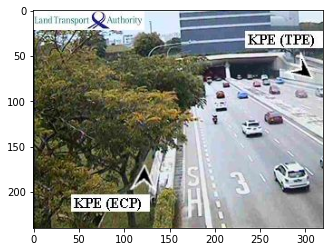

In [5]:
img = cv2.imread('Images Preprocessed\image_original.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Next, we resize the image to standardize the shape with OpenCV.

We resized the image to 300 x 300 for consistency.

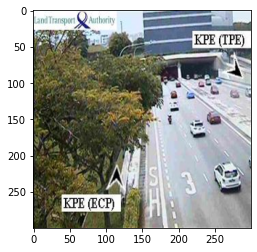

In [17]:
img = cv2.imread('Images Preprocessed\image_resized.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Remove text from image
Next, we want to preprocess the image. First, we want to remove all the words from the image as they might be misclassified as a vehicle.

To do so, we deployed keras_ocr as a text detector to remove the text in the image.

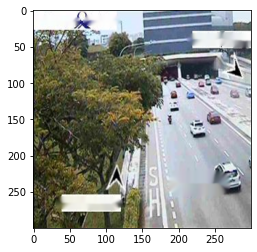

In [18]:
img = cv2.imread('Images Preprocessed\image_no_text.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Predict number of vehicles
We deployed a pretrained YOLOv4 model to count the number of vehicles in the image. 

There are other existing pretrained models, but the YOLOv4 model produces the best results, and does not need other filtering such as blurring and convertion to BW to operate.

https://github.com/opencv/opencv/issues/17479
https://pysource.com/2021/07/30/count-vehicles-on-images-with-opencv-and-deep-learning/#

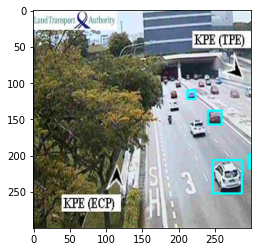

In [19]:
img = cv2.imread('Images Preprocessed\image_final.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Here, the number of cars detected is 3.

### Thoughts

Overall, the pipeline to extract the number of cars for the location (1.357098686, 103.902042) is decent enough.

However, there is a major issue with the time requirement to extract all the data.

The keras_ocr module to reject texts from image take a significant amount of time to operate.

Similarly, if not even so, the YOLOv4 model takes a much more significant amount of time to run.

As the study is performed under time and resources constrains, it may be impossible to run the model on the entire dataset:

    1) Data begins from 2016 to 2022: 7 years.

    2) Data is updated every 20 seconds: 7*365*24*60*3=11037600 images.

    3) There are 87 images ever time frame: 11037600*87=960271200 images.

    4) Under the assumption that it takes 5 seconds to process one image, it will take: 960271200*5=4801356000 seconds.

    5) This corresponds to 4801356000/60/60/24/365=152.25 years.

Hence, to make the study possible within the time span, I considered the following:

    1) We only select one month worth of data: 1/12 year. This is because it one month contains 30 days, which may be sufficient for training a model with only 1-2 parameters.

    2) Instead of extracting data from every 20 seconds, we extract the data every 30 minutes. We realized that traffic data do not vary that significantly; traffic jams can last 30 minutes or so. Hence, we do not need such high frequency of data, considering we are only expected to make predictions for the next 3 hours. 1*30*24*2=1440
    
    3) We only take the image of the selected coordinate (1.357098686, 103.902042), instead of all 87 images. While the other images may be correlated to the targeted coordinate, the majority of them are too far too make a significant impact as identified from google maps. Hence, we will have 1440 images.

    4) Under the assumption that it takes 5 seconds to process one image, it will take: 1440*5=7200 seconds.

    5) This corresponds to 7200/60/60=2 hours, which is a lot more manageable.
    
If there are sufficient time, we can increase the frequency of data recording from 30 minutes to 10 minutes or so, and perhaps include some of the images that are close to the targeted coordinate as it might be more correlated.

Also, we understand that the time between 7-9am is where people go to work, while 6-8pm is where people get off from work.

While people do not usually go to work on Saturday and Sunday, people still go out for recreational activities, which will bring traffic to similar level during those times.

## 3) Temperature Estimation
Next, we wish to estimate the temperature of the area near (1.357098686, 103.902042).

We realized that there are no temperature data for the location at exactly (1.357098686, 103.902042).

Hence, we only can make an estimate on the temperature, based on how close the available senors are to the coordinates. 

We set a threshold of the latitude and longitude, such that if the sensors are within the threshold of the targeted site, we will record the temperature measured.

If none are found, we simply take the average temperature of all the sensors.

Overall, I feel that the temperature will not be a good correlation:

    1) Temperature depends more on the time of the day, rather than the weather.
    
    2) While the weather (rain, thunder storm) does have an impact, it is more of an outlier considering the weather of SG, which is often sunny.
    
    3) Hence, we expect the day to have a higher temperature than the night time.

In [30]:
latitude_fix = 1.357098686 
longitude_fix = 103.902042

gap_lat = 0.2
gap_lon = 0.05

# Extract air temperature data
url = 'https://api.data.gov.sg/v1//environment/air-temperature'
response = urlopen(url)
json_data = response.read().decode('utf-8', 'replace')
df_temp = json.loads(json_data)

# Get status
temp_status = df_temp['api_info']['status'] 

# Get timestamp
temp_timestamp = df_temp['items'][0]['timestamp']

temp_date = temp_timestamp.split('T')[0]
temp_time_zone = temp_timestamp.split('T')[1]

temp_time = temp_time_zone.split('+')[0]
temp_time_SG = temp_time_zone.split('+')[1]

# Get readings
temp_readings = pd.DataFrame(df_temp['items'][0]['readings'])
temp_reading_type = df_temp['metadata']['reading_type']
temp_reading_unit = df_temp['metadata']['reading_unit']

# Get location
temp_stations =  pd.DataFrame.from_dict(df_temp['metadata']['stations'])
# Convert location into latitude and longitude
temp_stations[['latitude', 'longitude']] = temp_stations['location'].apply(pd.Series)
temp_stations = temp_stations.drop(['location'], axis=1)

# Combine all findings into a single DF
temp_stations['status'] = temp_status

temp_stations['status'] = temp_status
temp_stations['date'] = temp_date
temp_stations['time'] = temp_time
temp_stations['time zone'] = temp_time_SG

temp_stations = pd.concat([temp_stations, temp_readings], axis=1)
temp_stations['reading_type'] = temp_reading_type
temp_stations['reading_unit'] = temp_reading_unit
temp_stations.drop_duplicates()

temp_final = temp_stations

temp_final1 = temp_final[(temp_final['latitude'] < latitude_fix + gap_lat) &
                         (temp_final['latitude'] > latitude_fix - gap_lat) &
                         (temp_final['longitude'] < longitude_fix + gap_lon) &
                         (temp_final['longitude'] > longitude_fix - gap_lon)]

if len(temp_final1) == 0:
    temperature = np.mean(temp_final['value'])
else:
    temperature = np.mean(temp_final1['value'])
    
print(temperature)


33.3


## 4) Full Data Extraction Pipeline
Combining everything we mentioned above, we:
1) Generate a list of datetime with 30 minutes interval running from 20 Mar 2021 to 20 Mar 2022

2) For each datetime extract the traffic image at (1.357098686, 103.902042) 

    a) Save the time and image URL.
        
3) For each datetime, extract the temperature data

    a) Find the location closest to (1.357098686, 103.902042), and get the temperature.
    
    b) If none are found, take the average temperature of the entire SG.
    
4) With the image at (1.357098686, 103.902042)

    a) Reshape to (300, 300)
    
    b) Remove text from the image
    
    c) Deploy YOLOv4 to detect the number of vehicles in the image
    
5) Store the datetime, number of vehicles, temperature in a csv file.
    

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/12/vehicle-detection-and-counting-system-using-opencv/
# cars_cascade = cv2.CascadeClassifier('car.xml')
# bus_cascade = cv2.CascadeClassifier('Bus_front.xml')
# two_cascade = cv2.CascadeClassifier('two_wheeler.xml')

# https://github.com/Kalebu/Real-time-Vehicle-Dection-Python
# cars_cascade = cv2.CascadeClassifier('Models/haarcascade_car.xml')

# https://github.com/opencv/opencv/issues/17479
# https://pysource.com/2021/07/30/count-vehicles-on-images-with-opencv-and-deep-learning/#
from Models.vehicle_detector import VehicleDetector
vd = VehicleDetector()

pipeline = keras_ocr.pipeline.Pipeline()

latitude_fix = 1.357098686 
longitude_fix = 103.902042

gap_lat = 0.2
gap_lon = 0.05

from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%dT%H:%M:%S') for dt in 
       datetime_range(datetime(2021, 3, 20, 12), datetime(2022, 3, 20, 12), 
       timedelta(minutes=30))]

loop = 1
df_features = pd.DataFrame()

for date_time in dts:
    
    print('Loop ' + str(loop) + ' - Date time: ' + date_time)
    loop = loop + 1

    date_time_temp = date_time.replace(':','%3A')
    
    # Code executed here
    url_imag = ('https://api.data.gov.sg/v1/transport/traffic-images?date_time=' + date_time_temp)
    url_temp = ('https://api.data.gov.sg/v1//environment/air-temperature?date_time=' + date_time_temp)

    # Extract traffic image
    response = urlopen(url_imag)
    json_data = response.read().decode('utf-8', 'replace')
    df_imag = json.loads(json_data)
    
    try: 
        imag_status = df_imag['api_info']['status']
        imag_timestamp = df_imag['items'][0]['timestamp']
        
        imag_date = imag_timestamp.split('T')[0]
        imag_time_zone = imag_timestamp.split('T')[1]
        
        imag_time = imag_time_zone.split('+')[0]
        imag_time_SG = imag_time_zone.split('+')[1]
        
        imag_cameras = df_imag['items'][0]['cameras']
        
        imag_cameras = pd.DataFrame.from_dict(imag_cameras)
        
        # Convert location into latitude and longitude
        imag_cameras[['latitude', 'longitude']] = imag_cameras['location'].apply(pd.Series)
        imag_cameras = imag_cameras.drop(['location'], axis=1)
        
        imag_cameras[['height', 'width', 'md5']] = imag_cameras['image_metadata'].apply(pd.Series)
        imag_cameras = imag_cameras.drop(['image_metadata'], axis=1)
        
        imag_cameras['status'] = imag_status
        imag_cameras['date'] = imag_date
        imag_cameras['time'] = imag_time
        imag_cameras['time zone'] = imag_time_SG
        imag_cameras.drop_duplicates()
        
        imag_cameras = imag_cameras.sort_values(by=['camera_id'])
        imag_cameras = imag_cameras.loc[imag_cameras['latitude']==1.357098686].reset_index(drop=True)
        imag_final = imag_cameras
        
    except:
        break
    
    # Extract air temperature data
    response = urlopen(url_temp)
    json_data = response.read().decode('utf-8', 'replace')
    df_temp = json.loads(json_data)
    
    # Get status
    temp_status = df_temp['api_info']['status'] 
    
    # Get timestamp
    temp_timestamp = df_temp['items'][0]['timestamp']
    
    temp_date = temp_timestamp.split('T')[0]
    temp_time_zone = temp_timestamp.split('T')[1]
    
    temp_time = temp_time_zone.split('+')[0]
    temp_time_SG = temp_time_zone.split('+')[1]
    
    # Get readings
    temp_readings = pd.DataFrame(df_temp['items'][0]['readings'])
    temp_reading_type = df_temp['metadata']['reading_type']
    temp_reading_unit = df_temp['metadata']['reading_unit']
    
    # Get location
    temp_stations =  pd.DataFrame.from_dict(df_temp['metadata']['stations'])
    # Convert location into latitude and longitude
    temp_stations[['latitude', 'longitude']] = temp_stations['location'].apply(pd.Series)
    temp_stations = temp_stations.drop(['location'], axis=1)
    
    # Combine all findings into a single DF
    temp_stations['status'] = temp_status
    
    temp_stations['status'] = temp_status
    temp_stations['date'] = temp_date
    temp_stations['time'] = temp_time
    temp_stations['time zone'] = temp_time_SG
    
    temp_stations = pd.concat([temp_stations, temp_readings], axis=1)
    temp_stations['reading_type'] = temp_reading_type
    temp_stations['reading_unit'] = temp_reading_unit
    temp_stations.drop_duplicates()
    
    temp_final = temp_stations
    
    temp_final1 = temp_final[(temp_final['latitude'] < latitude_fix + gap_lat) &
                             (temp_final['latitude'] > latitude_fix - gap_lat) &
                             (temp_final['longitude'] < longitude_fix + gap_lon) &
                             (temp_final['longitude'] > longitude_fix - gap_lon)]
    
    if len(temp_final1) == 0:
        temperature = np.mean(temp_final['value'])
    else:
        temperature = np.mean(temp_final1['value'])
    
    no_of_cars = []
    
    for i in (range(len(imag_final)))
    
        time1 = imag_final['time'][i].replace(':','_')
        date = imag_final['date'][i].replace('-','_')
        
        camera_id = imag_final['camera_id'][i]
        url = imag_final['image'][i]
            
        if not os.path.exists('Images Checked/' + camera_id):
            os.makedirs('Images Checked/' + camera_id)
        
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content))
            
            newsize = (300, 300)
            image = image.resize(newsize)
            image = np.array(image)
            
            image_no_text = inpaint_text(image, pipeline)
            image_no_text = Image.fromarray(image_no_text)           
            
            image_no_text = np.array(image_no_text)
            cars = vd.detect_vehicles(image_no_text)
            
            for (x, y, w, h) in cars:
                cv2.rectangle(image, (x, y), (x+w,y+h), color=(0, 255, 255), thickness=2)
        
            image = Image.fromarray(image)
            image.save('Images Checked/' + camera_id + 
                       '/' + camera_id + '_' + date + '__' + time1 + '.jpg')
            print(str(loop) + ' : ' + camera_id + ' - No of cars: ' + str(len(cars)))
            no_of_cars.append(len(cars))
            
        except:
            print(str(loop) + ' : ' + camera_id + ' - No of cars: 0 -  ERROR')
            
            no_of_cars.append(0)
        
    columns_name = ['DateTime'] + list(imag_final['camera_id']) + ['Temp']
    
    data = [date_time] + no_of_cars + [temperature]
    data = pd.DataFrame(data)
    data = data.transpose()
    data.columns = columns_name
    
    if len(df_features) == 0:
        df_features = pd.DataFrame(columns = columns_name)
    df_features = df_features.append(data)
    
    df_features.to_csv('Results\features.csv')

## 5) Data Visualization

We pick a random day and plot the traffic and temperature against time.

We realized that the traffic and temperature is correlated to some extent.

Next, we plot the entire's month data and see if the data is:

    1) Seasonality - Periodic
    
    2) Stationarity - constant mean and variance
    
Finally, we take the average of the traffic and temperature across all the time (in hours) to get the average trend of the traffic and temperature throughout the day.

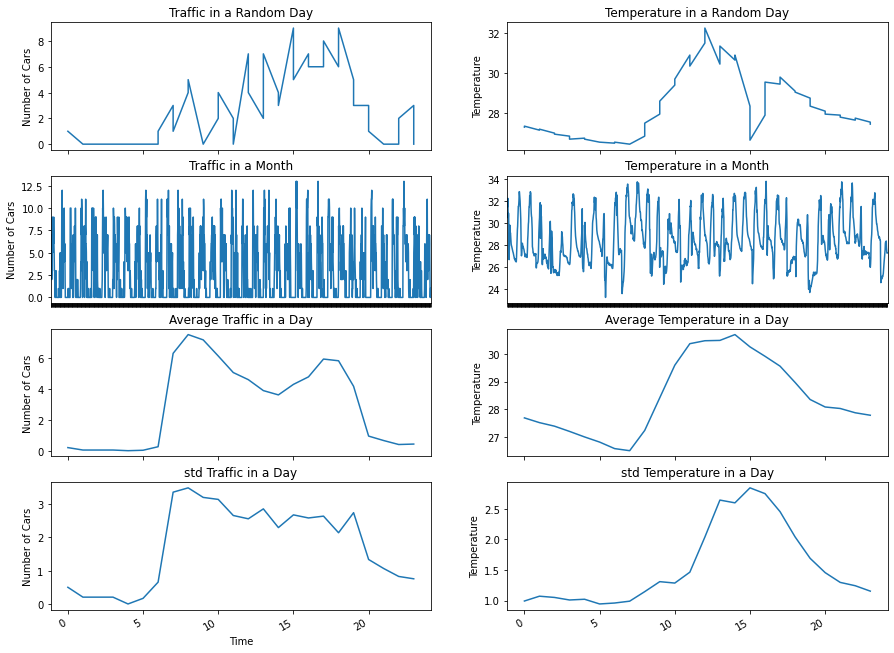

<Figure size 432x288 with 0 Axes>

In [60]:
df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour

fig, axs = plt.subplots(4, 2, figsize=(15,12))

# A random day
df_day = df[0:48]
df_day = df_day.drop_duplicates(keep='last').reset_index(drop=True)
df_day = df_day.sort_values(by=['hour']).reset_index(drop=True)

axs[0, 0].plot('hour', '1006', data=df_day)
axs[0, 0].set_title('Traffic in a Random Day')
axs[0, 0].set_ylabel('Number of Cars')

axs[0, 1].plot('hour', 'Temp', data=df_day)
axs[0, 1].set_title('Temperature in a Random Day')
axs[0, 1].set_ylabel('Temperature')



# Per over a year
axs[1, 0].plot('DateTime', '1006', data=df)
axs[1, 0].set_xlim(df['DateTime'].min()-pd.Timedelta(1,'h'),
                   df['DateTime'].max()+pd.Timedelta(1,'h'))
axs[1, 0].xaxis.set_major_locator(md.HourLocator(interval = 1))
axs[1, 0].xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
axs[1, 0].set_title('Traffic in a Month')
axs[1, 0].set_ylabel('Number of Cars')

axs[1, 1].plot('DateTime', 'Temp', data=df)
axs[1, 1].set_xlim(df['DateTime'].min()-pd.Timedelta(1,'h'),
                   df['DateTime'].max()+pd.Timedelta(1,'h'))
axs[1, 1].xaxis.set_major_locator(md.HourLocator(interval = 1))
axs[1, 1].xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
fig.autofmt_xdate()
axs[1, 1].set_title('Temperature in a Month')
axs[1, 1].set_ylabel('Temperature')



# Get average per hour
df['hour'] = df['DateTime'].dt.hour
df_day = df.copy()
df_day[['1006', 'Temp']] = df_day[['1006', 'Temp']].groupby(df_day['hour']).transform('mean')

# Plot average per hour
df_day = df_day[0:48]
df_day = df_day.drop_duplicates(keep='last').reset_index(drop=True)
df_day = df_day.sort_values(by=['hour']).reset_index(drop=True)

axs[2, 0].plot('hour', '1006', data=df_day)
axs[2, 0].set_title('Average Traffic in a Day')
axs[2, 0].set_ylabel('Number of Cars')

axs[2, 1].plot('hour', 'Temp', data=df_day)
axs[2, 1].set_title('Average Temperature in a Day')
axs[2, 1].set_ylabel('Temperature')



# Get std per hour
df['hour'] = df['DateTime'].dt.hour
df_day = df.copy()
df_day[['1006', 'Temp']] = df_day[['1006', 'Temp']].groupby(df_day['hour']).transform('std')

# Plot std per hour
df_day = df_day[0:48]
df_day = df_day.drop_duplicates(keep='last').reset_index(drop=True)
df_day = df_day.sort_values(by=['hour']).reset_index(drop=True)

axs[3, 0].plot('hour', '1006', data=df_day)
axs[3, 0].set_title('std Traffic in a Day')
axs[3, 0].set_xlabel('Time')
axs[3, 0].set_ylabel('Number of Cars')

axs[3, 1].plot('hour', 'Temp', data=df_day)
axs[3, 1].set_title('std Temperature in a Day')
axs[3, 0].set_xlabel('Time')
axs[3, 1].set_ylabel('Temperature')


# Save plot
plt.show()  
plt.savefig('Results\Data visualization.png')

# Seasonality - Periodic
# Stationarity - constant mean and variance

We realized that the average traffic and average temperature per day is quite correlated. 

However, the std of the distribution appears extremely different. Hence, it may be very difficult to perform prediction of traffic using temperature.

## 6) Perform Regression (Traffic vs Time)

With the data, we can perform regression to see if given the time of the day 0-23 hours (24 hours clock), can we predict the number of cars in the traffic at the targeted coordinate.

X = time (hours)

y = number of cars

We rescale the X values and perform regression using linear regression with polynormal features.

We deployed the Coefficient of determination (r^2) to measure the model performance.

The model performed well as the time and traffic is highly correlated.

(1188, 1) (1188,)
(510, 1) (510,)
Results:

Polynomial degree 1: train score=0.024, test score=0.027
Polynomial degree 1 mse: train score=10.999, test score=11.87

Polynomial degree 2: train score=0.371, test score=0.382
Polynomial degree 2 mse: train score=7.096, test score=7.545

Polynomial degree 3: train score=0.377, test score=0.392
Polynomial degree 3 mse: train score=7.019, test score=7.416

Polynomial degree 6: train score=0.436, test score=0.448
Polynomial degree 6 mse: train score=6.358, test score=6.741

Polynomial degree 10: train score=0.573, test score=0.586
Polynomial degree 10 mse: train score=4.819, test score=5.057

Polynomial degree 15: train score=0.594, test score=0.607
Polynomial degree 15 mse: train score=4.576, test score=4.798

Polynomial degree 20: train score=0.607, test score=0.609
Polynomial degree 20 mse: train score=4.436, test score=4.773

The predicted number of cars is: 7


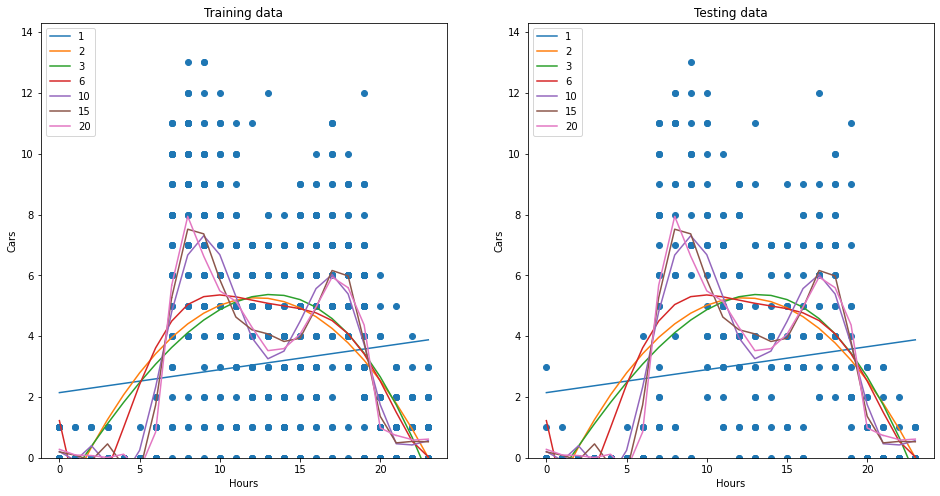

In [98]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour

y = np.array(df['1006'])
X = np.array(df['hour']).reshape((-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y,                                     
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

scaler = MinMaxScaler()
#scaler = Normalizer()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

degrees = [1, 2, 3, 6, 10, 15, 20]

y_train_pred = np.zeros((len(X_train_scale), len(degrees)))
y_test_pred = np.zeros((len(X_test_scale), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_scale, y_train)
    
    with open('Models Trained/model_time_' + str(degree) + '.pkl', 'wb') as files:
        pickle.dump(model, files)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train_scale)
    y_test_pred[:, i] = model.predict(X_test_scale)
    
    
plt.figure(figsize=(16, 8))

y_max = np.max(y_train)*1.1
y_min = np.min(y_train)*0.9

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.xlabel('Hours')
plt.ylabel('Cars')
plt.title("Training data")
for i, degree in enumerate(degrees):
        
    dummy = np.concatenate((X_train, y_train_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.xlabel('Hours')
plt.ylabel('Cars')
plt.title("Testing data")
for i, degree in enumerate(degrees): 
    
    dummy = np.concatenate((X_test, y_test_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
plt.savefig('Forcasting_Time.png')
    
# compare r2 for train and test sets (for all polynomial fits)
print("Results:")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train, y_train_pred[:, i]), 3)
    test_r2 = round(r2_score(y_test, y_test_pred[:, i]), 3)
    print("\nPolynomial degree {0}: train score={1}, test score={2}".format(degree, train_r2, test_r2))
    
    train_mse = round(mean_squared_error(y_train, y_train_pred[:, i]), 3)
    test_mse = round(mean_squared_error(y_test, y_test_pred[:, i]), 3)
    print("Polynomial degree {0} mse: train score={1}, test score={2}".format(degree, train_mse, test_mse))
    
# Between 0 to 23
input_hour = 8
input_hour = np.array(input_hour).reshape((-1,1))
input_hour = scaler.transform(input_hour)
predict = model.predict(input_hour)
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

## 7) Perform Regression (Traffic vs Temperature)

X = temperature

y = number of cars

We rescale the X values and perform regression using linear regression with polynormal features.

We deployed the Coefficient of determination (r^2) to measure the model performance.

(1188, 1) (1188,)
(510, 1) (510,)
Results:

Polynomial degree 1: train score=0.054, test score=0.05
Polynomial degree 1 mse: train score=10.666, test score=11.592

Polynomial degree 2: train score=0.057, test score=0.05
Polynomial degree 2 mse: train score=10.634, test score=11.593

Polynomial degree 3: train score=0.075, test score=0.081
Polynomial degree 3 mse: train score=10.428, test score=11.21

Polynomial degree 6: train score=0.102, test score=0.088
Polynomial degree 6 mse: train score=10.127, test score=11.131

Polynomial degree 10: train score=0.108, test score=0.09
Polynomial degree 10 mse: train score=10.054, test score=11.098

Polynomial degree 15: train score=0.109, test score=0.092
Polynomial degree 15 mse: train score=10.05, test score=11.078

Polynomial degree 20: train score=0.114, test score=0.078
Polynomial degree 20 mse: train score=9.985, test score=11.246

The predicted number of cars is: 5


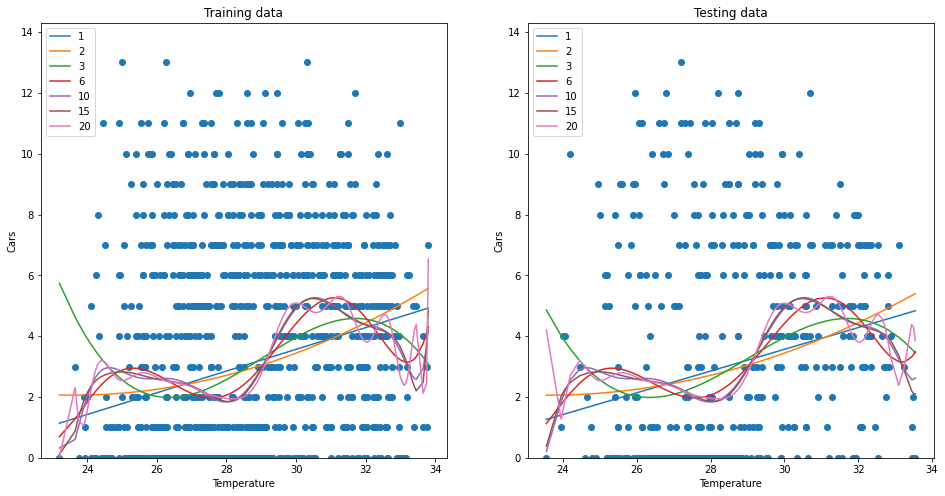

In [99]:
df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour
df = df.drop(['DateTime'], axis=1)

y = np.array(df['1006'])
X = np.array(df['Temp']).reshape((-1,1))


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,                                     
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

scaler = MinMaxScaler()
#scaler = Normalizer()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

degrees = [1, 2, 3, 6, 10, 15, 20]

y_train_pred = np.zeros((len(X_train_scale), len(degrees)))
y_test_pred = np.zeros((len(X_test_scale), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_scale, y_train)
    
    with open('Models Trained/model_temp_' + str(degree) + '.pkl', 'wb') as files:
        pickle.dump(model, files)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train_scale)
    y_test_pred[:, i] = model.predict(X_test_scale)
    
plt.figure(figsize=(16, 8))

y_max = np.max(y_train)*1.1
y_min = np.min(y_train)*0.9

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.xlabel('Temperature')
plt.ylabel('Cars')
plt.title("Training data")
for i, degree in enumerate(degrees):
        
    dummy = np.concatenate((X_train, y_train_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.xlabel('Temperature')
plt.ylabel('Cars')
plt.title("Testing data")
for i, degree in enumerate(degrees): 
    
    dummy = np.concatenate((X_test, y_test_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
plt.savefig('Forcasting_Time.png')
    
# compare r2 for train and test sets (for all polynomial fits)
print("Results:")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train, y_train_pred[:, i]), 3)
    test_r2 = round(r2_score(y_test, y_test_pred[:, i]), 3)
    print("\nPolynomial degree {0}: train score={1}, test score={2}".format(degree, train_r2, test_r2))
    
    train_mse = round(mean_squared_error(y_train, y_train_pred[:, i]), 3)
    test_mse = round(mean_squared_error(y_test, y_test_pred[:, i]), 3)
    print("Polynomial degree {0} mse: train score={1}, test score={2}".format(degree, train_mse, test_mse))
    
# Between 24-34
input_hour = 30
input_hour = np.array(input_hour).reshape((-1,1))
input_hour = scaler.transform(input_hour)
predict = model.predict(input_hour)
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

The model performed poorly due to the huge variation of temperature.

## 8) Perform Regression (Traffic vs Time + Temperature)

X = time and temperature

y = number of cars

We rescale the X values and perform regression using linear regression with polynormal features.

We deployed the Coefficient of determination (r^2) to measure the model performance.

(1188, 2) (1188,)
(510, 2) (510,)
Results:

Polynomial degree 1 r2: train score=0.345, test score=0.348
Polynomial degree 1 mse: train score=7.386, test score=7.955

Polynomial degree 2 r2: train score=0.399, test score=0.422
Polynomial degree 2 mse: train score=6.78, test score=7.047

Polynomial degree 3 r2: train score=0.407, test score=0.425
Polynomial degree 3 mse: train score=6.691, test score=7.015

Polynomial degree 6 r2: train score=0.541, test score=0.557
Polynomial degree 6 mse: train score=5.172, test score=5.409

Polynomial degree 10 r2: train score=0.556, test score=0.565
Polynomial degree 10 mse: train score=5.004, test score=5.305

Polynomial degree 15 r2: train score=0.558, test score=0.567
Polynomial degree 15 mse: train score=4.978, test score=5.28

The predicted number of cars is: 6


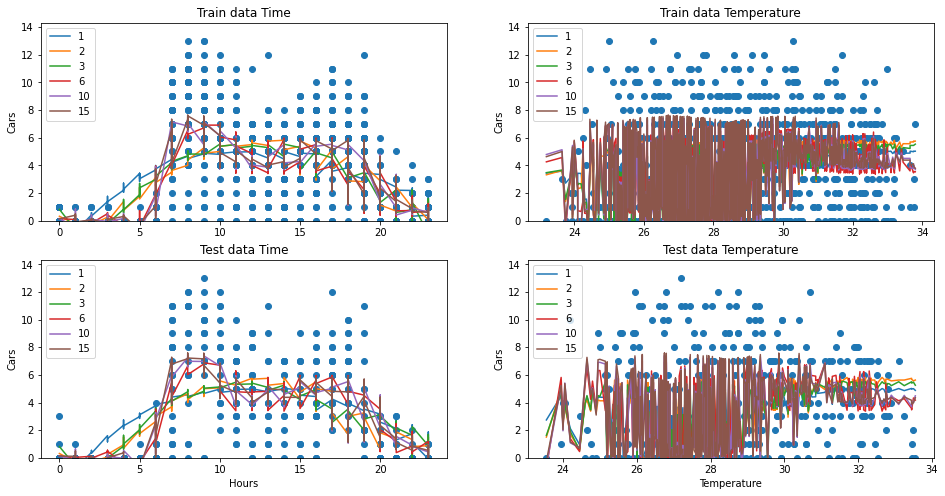

In [100]:
df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour
df = df.drop(['DateTime'], axis=1)

y = np.array(df['1006'])
X = np.array(df[['hour', 'Temp']]).reshape((-1,2))


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,                                     
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#scaler = MinMaxScaler()
scaler = Normalizer()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

degrees = [1, 2, 3, 6, 10, 15]

y_train_pred = np.zeros((len(X_train_scale), len(degrees)))
y_test_pred = np.zeros((len(X_test_scale), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_scale, y_train)
    
    with open('Models Trained/model_time_temp_' + str(degree) + '.pkl', 'wb') as files:
        pickle.dump(model, files)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train_scale)
    y_test_pred[:, i] = model.predict(X_test_scale)
    
plt.figure(figsize=(16, 8))

y_max = np.max(y_train)*1.1
y_min = np.min(y_train)*0.9

# train data
plt.subplot(221)
plt.scatter(X_train[:,0], y_train)
#plt.xlabel('Hours')
plt.ylabel('Cars')
plt.title("Train data Time")
for i, degree in enumerate(degrees):
        
    dummy = np.concatenate((X_train[:,0].reshape((-1,1)), 
                            y_train_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
plt.subplot(222)
plt.scatter(X_train[:,1], y_train)
#plt.xlabel('Temperature')
plt.ylabel('Cars')
plt.title("Train data Temperature")
for i, degree in enumerate(degrees):
        
    dummy = np.concatenate((X_train[:,1].reshape((-1,1)), 
                            y_train_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
# test data
plt.subplot(223)
plt.scatter(X_test[:,0], y_test)
plt.xlabel('Hours')
plt.ylabel('Cars')
plt.title("Test data Time")
for i, degree in enumerate(degrees): 
    
    dummy = np.concatenate((X_test[:,0].reshape((-1,1)), 
                            y_test_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
plt.subplot(224)
plt.scatter(X_test[:,1], y_test)
plt.xlabel('Temperature')
plt.ylabel('Cars')
plt.title("Test data Temperature")
for i, degree in enumerate(degrees): 
    
    dummy = np.concatenate((X_test[:,1].reshape((-1,1)), 
                            y_test_pred[:, i].reshape((-1,1))), axis=1)
    dummy = pd.DataFrame(dummy)
    dummy = dummy.drop_duplicates(keep='last')
    dummy = dummy.sort_values(by=[0])
    plt.plot(dummy[0], dummy[1], label=str(degree))
    plt.legend(loc='upper left')
    plt.ylim([y_min, y_max])
    
plt.savefig('Forcasting_Both.png')
    
# compare r2 for train and test sets (for all polynomial fits)
print("Results:")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train, y_train_pred[:, i]), 3)
    test_r2 = round(r2_score(y_test, y_test_pred[:, i]), 3)
    print("\nPolynomial degree {0} r2: train score={1}, test score={2}".format(degree, train_r2, test_r2))
    
    train_mse = round(mean_squared_error(y_train, y_train_pred[:, i]), 3)
    test_mse = round(mean_squared_error(y_test, y_test_pred[:, i]), 3)
    print("Polynomial degree {0} mse: train score={1}, test score={2}".format(degree, train_mse, test_mse))
    
input_hour = np.array((8, 30))
input_hour = np.array(input_hour).reshape((-1,2))
input_hour = scaler.transform(input_hour)
predict = model.predict(input_hour)
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

The model overfitted and cannot perform well with both features.

## 9 Check for Correlation between Traffic and Temperature

      1006   Temp  hour
0      7.0  31.50    12
1      4.0  32.25    12
2      7.0  31.35    13
3      2.0  30.45    13
4      3.0  30.90    14
...    ...    ...   ...
1693   6.0  28.35    18
1694   3.0  27.75    19
1695   0.0  27.45    19
1696   0.0  27.25    20
1697   1.0  27.25    20

[1698 rows x 3 columns]
cars: mean=3.025 stdv=3.399
temp: mean=28.463 stdv=2.154


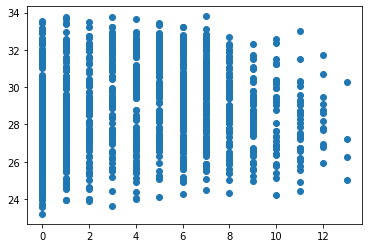

In [25]:
df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour
df = df.drop(['DateTime'], axis=1)

print(df)

cars = df['1006']
temp = df['Temp']

print('cars: mean=%.3f stdv=%.3f' % (np.mean(cars), np.std(cars)))
print('temp: mean=%.3f stdv=%.3f' % (np.mean(temp), np.std(temp)))

plt.scatter(cars, temp)
plt.show()

## 10) Best fit line (Traffic vs Time)

In [94]:
df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)

df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Get average per hour
df['hour'] = df['DateTime'].dt.hour
df_day = df.copy()
df_day[['1006', 'Temp']] = df_day[['1006', 'Temp']].groupby(df_day['hour']).transform('mean')

model = df_day.drop(['DateTime', 'Temp'], axis=1)
model = model.drop_duplicates(keep='last').reset_index(drop=True)
model = model.sort_values(by=['hour']).reset_index(drop=True)

print(model)

# Between 0 to 23
input_hour = 10

predict = model.loc[model['hour']==input_hour]['1006']
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

        1006  hour
0   0.200000     0
1   0.042857     1
2   0.042857     2
3   0.042857     3
4   0.000000     4
5   0.028571     5
6   0.257143     6
7   6.300000     7
8   7.514286     8
9   7.171429     9
10  6.128571    10
11  5.057143    11
12  4.597222    12
13  3.888889    13
14  3.611111    14
15  4.291667    15
16  4.777778    16
17  5.930556    17
18  5.819444    18
19  4.166667    19
20  0.944444    20
21  0.657143    21
22  0.400000    22
23  0.428571    23

The predicted number of cars is: 6


In [101]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour

y = np.array(df['1006'])
X = np.array(df['hour'])

X_train, X_test, y_train, y_test = train_test_split(X, y,                                     
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


model = pd.DataFrame()
model['hour'] = X_train
model['1006'] = y_train

model[['1006']] = model[['1006']].groupby(model['hour']).transform('mean')
model = model.drop_duplicates(keep='last').reset_index(drop=True)
model = model.sort_values(by=['hour']).reset_index(drop=True)


y_test_pred = []
for i in range(len(X_test)):
    
    X = X_test[i]
    y = y_test[i]
    
    predict = model.loc[model['hour']==X]['1006']
    y_test_pred.append(predict)

    
y_train_pred = []
for i in range(len(X_train)):
    
    X = X_train[i]
    y = y_train[i]
    
    predict = model.loc[model['hour']==X]['1006']
    y_train_pred.append(predict)
    
    
# compare r2 for train and test sets (for all polynomial fits)
print("Results: \n")
train_r2 = round(r2_score(y_train, y_train_pred), 3)
test_r2 = round(r2_score(y_test, y_test_pred), 3)
print("Best fit line r2: train score={1}, test score={2}".format(degree, train_r2, test_r2))

train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
print("Best fit line mse: train score={1}, test score={2}".format(degree, train_mse, test_mse))
    
# Between 0 to 23
input_hour = 10

predict = model.loc[model['hour']==input_hour]['1006']
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

(1188,) (1188,)
(510,) (510,)
Results: 

Best fit line r2: train score=0.615, test score=0.611
Best fit line mse: train score=4.345, test score=4.742

The predicted number of cars is: 5


## 11) Best fit line (Traffic vs Temperature)

In [86]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

df = pd.read_csv('Results\\features - Final.csv')
df = df.fillna(0)
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df['hour'] = df['DateTime'].dt.hour

y = np.array(df['1006'])
X = np.array(df['Temp'])

X_train, X_test, y_train, y_test = train_test_split(X, y,                                     
                                                    train_size = 0.7, 
                                                    test_size = 0.3, 
                                                    random_state = 10)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


model = pd.DataFrame()
model['Temp'] = X_train
model['1006'] = y_train

model[['1006']] = model[['1006']].groupby(model['Temp']).transform('mean')
model['Temp'] = model['Temp'].astype(int)
model = model.drop_duplicates(subset=['Temp'], keep='last').reset_index(drop=True)
model = model.sort_values(by=['Temp']).reset_index(drop=True)

print(model)

y_test_pred = []
for i in range(len(X_test)):
    
    X = int(X_test[i])
    y = y_test[i]
    
    predict = model.loc[model['Temp']==X]['1006']
    y_test_pred.append(predict)

    
y_train_pred = []
for i in range(len(X_train)):
    
    X = int(X_train[i])
    y = y_train[i]
    
    predict = model.loc[model['Temp']==X]['1006']
    y_train_pred.append(predict)
    
    
# compare r2 for train and test sets (for all polynomial fits)
print("Results: \n")
train_r2 = round(r2_score(y_train, y_train_pred), 3)
test_r2 = round(r2_score(y_test, y_test_pred), 3)
print("Best fit line r2: train score={1}, test score={2}".format(degree, train_r2, test_r2))

train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
print("Best fit line mse: train score={1}, test score={2}".format(degree, train_mse, test_mse))

    
# Between 24-34
input_hour = 30

predict = model.loc[model['Temp']==input_hour]['1006']
predict = int(predict)
print('\nThe predicted number of cars is: ' + str(predict))

(1188,) (1188,)
(510,) (510,)
    Temp      1006
0     23  3.000000
1     24  7.000000
2     25  5.000000
3     26  3.400000
4     27  0.777778
5     28  2.157895
6     29  3.666667
7     30  5.000000
8     31  2.833333
9     32  2.000000
10    33  0.000000
R-squared values: 

Best fit line r2: train score=-0.082, test score=-0.051
Best fit line mse: train score=12.194, test score=12.823

The predicted number of cars is: 5


## 12) Summary

The summary of test r2 and mse are displayed below:

Model | Variables | r2 | mse
--- | --- | --- |  ---
Regression | Time | 0.609 | 4.773
Regression | Temp | 0.078 | 11.246
Regression | Time and Temp | 0.567 | 5.28
Best fit | Time | 0.611 | 4.74
Best fit | Temp | -0.051 | 12.823

Overall, the best fit line with time only achieved the best results.

## 13) Conclusion
Time is a good measure to predict traffic at a certain place, while temperature may not be as appropriate due to the huge variation of weather.

In future work, to improve the model, we can:

    1) Use more data, with a shorter time interval, to improve the precision of the model.

    2) Use all information of all the images (87), the number of vehicles can be correlated.
    
    3) Use all the temperature sensors around SG to make a better temperature prediction.

    4) Train a YOLOv4 model that can detect cars, bus, and other vehicles, which may not be detected in the current study.
    
    5) Instead of using time in the form of hours, accounting for the week, month, day, or year may improve results. For instance, weekends should have different number of cars at different time. Meanwhile, months such as December may have more people taking leave and offs, reducing traffic in those months. Finally, for year 2020, 2021, and 2022, the situation with COVID19 may affect the traffic as people work from home more often. 